# part 1


In [5]:
import pandas as pd
from pathlib import Path

# Loaded  the CSV
df = pd.read_csv("C:\\Users\\Win10\\Downloads\\archive (2)\\dataset_ml\\AWCustomers.csv")

selected_features = [
    "Education", "Occupation", "Gender", "MaritalStatus", "HomeOwnerFlag",
    "NumberCarsOwned", "NumberChildrenAtHome", "TotalChildren",
    "YearlyIncome", "CountryRegionName", "StateProvinceName", "City",
    "BirthDate", "LastUpdated"
]
df_sel = df[selected_features].copy()

# Derive Age from BirthDate and LastUpdated
def compute_age(row):
    bd = pd.to_datetime(row["BirthDate"], errors="coerce")
    ref = pd.to_datetime(row["LastUpdated"], errors="coerce")
    if pd.isna(ref):
        ref = pd.Timestamp.today().normalize()
    if pd.isna(bd):
        return None
    return int((ref - bd).days / 365.25)

df_sel["Age"] = df_sel.apply(compute_age, axis=1)

# Drop BirthDate now (Age replaces it)
df_sel.drop(columns=["BirthDate"], inplace=True)

print(df_sel.head())


         Education      Occupation Gender MaritalStatus  HomeOwnerFlag  \
0        Bachelors        Clerical      M             M              1   
1  Partial College        Clerical      M             M              1   
2        Bachelors        Clerical      F             S              0   
3  Partial College  Skilled Manual      M             M              1   
4  Partial College  Skilled Manual      M             S              1   

   NumberCarsOwned  NumberChildrenAtHome  TotalChildren  YearlyIncome  \
0                3                     0              1         81916   
1                2                     1              2         81076   
2                3                     0              0         86387   
3                2                     1              2         61481   
4                1                     0              0         51804   

  CountryRegionName    StateProvinceName         City LastUpdated  Age  
0         Australia      New South Wales   

# part 2

In [6]:
df_proc=df_sel.copy()

#DEFINE NUMERICAL AND CATEGORIAL COLUMNS 
numeric_cols = ["YearlyIncome", "NumberCarsOwned", "NumberChildrenAtHome", "TotalChildren", "Age"]
categorical_cols = [c for c in df_proc.columns if c not in numeric_cols + ["LastUpdated"]]
for c in numeric_cols:
    df_proc[c] = pd.to_numeric(df_proc[c], errors="coerce")
    df_proc[c].fillna(df_proc[c].median(), inplace=True)

for c in categorical_cols:
    df_proc[c] = df_proc[c].astype(object).where(~df_proc[c].isna(), other="Unknown")

print(df_proc.isnull().sum()) 


C:\Users\Win10\AppData\Local\Temp\ipykernel_6348\2155529775.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_proc[c].fillna(df_proc[c].median(), inplace=True)
C:\Users\Win10\AppData\Local\Temp\ipykernel_6348\2155529775.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Education               0
Occupation              0
Gender                  0
MaritalStatus           0
HomeOwnerFlag           0
NumberCarsOwned         0
NumberChildrenAtHome    0
TotalChildren           0
YearlyIncome            0
CountryRegionName       0
StateProvinceName       0
City                    0
LastUpdated             0
Age                     0
dtype: int64


In [7]:
df_proc["IncomeBin"] = pd.qcut(df_proc["YearlyIncome"], q=5, labels=False, duplicates="drop")

# Discretize Age into 5 equal-width bins
df_proc["AgeBin"] = pd.cut(df_proc["Age"], bins=5, labels=False, include_lowest=True)

print(df_proc[["YearlyIncome", "IncomeBin", "Age", "AgeBin"]].head())


   YearlyIncome  IncomeBin  Age  AgeBin
0         81916          3   29       0
1         81076          3   44       1
2         86387          3   31       1
3         61481          2   39       1
4         51804          1   42       1


In [8]:
def min_max_scale(s):
    return (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else 0

df_minmax = df_proc[numeric_cols].apply(min_max_scale)
print(df_minmax.head())


   YearlyIncome  NumberCarsOwned  NumberChildrenAtHome  TotalChildren  \
0      0.496842              0.6              0.000000       0.333333   
1      0.489453              0.4              0.333333       0.666667   
2      0.536172              0.6              0.000000       0.000000   
3      0.317083              0.4              0.333333       0.666667   
4      0.231958              0.2              0.000000       0.000000   

        Age  
0  0.185714  
1  0.400000  
2  0.214286  
3  0.328571  
4  0.371429  


In [9]:
def zscore(s):
    return (s - s.mean()) / s.std(ddof=0) if s.std(ddof=0) != 0 else 0

df_zscore = df_proc[numeric_cols].apply(zscore)
print(df_zscore.head())


   YearlyIncome  NumberCarsOwned  NumberChildrenAtHome  TotalChildren  \
0      0.298555         1.892524             -0.594371       0.161342   
1      0.271180         0.798389              1.163279       1.239753   
2      0.444261         1.892524             -0.594371      -0.917069   
3     -0.367401         0.798389              1.163279       1.239753   
4     -0.682765        -0.295746             -0.594371      -0.917069   

        Age  
0 -0.495997  
1  0.836774  
2 -0.318294  
3  0.392517  
4  0.659071  


In [10]:
categorical_for_ohe = [c for c in df_proc.columns if c not in numeric_cols + ["LastUpdated"]]
df_ohe = pd.get_dummies(df_proc[categorical_for_ohe], drop_first=False, dtype=int)

print(df_ohe.head())


   IncomeBin  AgeBin  Education_Bachelors  Education_Graduate Degree  \
0          3       0                    1                          0   
1          3       1                    0                          0   
2          3       1                    1                          0   
3          2       1                    0                          0   
4          1       1                    0                          0   

   Education_High School  Education_Partial College  \
0                      0                          0   
1                      0                          1   
2                      0                          0   
3                      0                          1   
4                      0                          1   

   Education_Partial High School  Occupation_Clerical  Occupation_Management  \
0                              0                    1                      0   
1                              0                    1                      0

# part 3

In [11]:
# Numeric standardized
X_numeric_std = df_zscore.copy()

# Binary categorical
X_binary = df_ohe.copy()

# Full feature space (numeric + categorical)
X_full = pd.concat([X_numeric_std, X_binary], axis=1)


In [12]:
import numpy as np
from math import sqrt

def simple_matching_coefficient(x, y):
    matches = np.sum(x == y)
    return matches / len(x)

def jaccard_similarity(x, y):
    xb, yb = (x > 0).astype(int), (y > 0).astype(int)
    intersection = np.sum((xb == 1) & (yb == 1))
    union = np.sum((xb == 1) | (yb == 1))
    return intersection / union if union != 0 else 0

def cosine_similarity(x, y):
    num = np.dot(x, y)
    den = sqrt(np.dot(x, x)) * sqrt(np.dot(y, y))
    return num / den if den != 0 else 0


In [13]:
i, j = 0, 1  

x_bin_i, x_bin_j = X_binary.iloc[i].to_numpy(), X_binary.iloc[j].to_numpy()
x_full_i, x_full_j = X_full.iloc[i].to_numpy(), X_full.iloc[j].to_numpy()

smc = simple_matching_coefficient(x_bin_i, x_bin_j)
jac = jaccard_similarity(x_bin_i, x_bin_j)
cos = cosine_similarity(x_full_i, x_full_j)

print("Simple Matching Coefficient:", smc)
print("Jaccard Similarity:", jac)
print("Cosine Similarity:", cos)


Simple Matching Coefficient: 0.9740634005763689
Jaccard Similarity: 0.35714285714285715
Cosine Similarity: 0.6279787104035389


Correlation (NumberCarsOwned ~ YearlyIncome): 0.4773001523631683


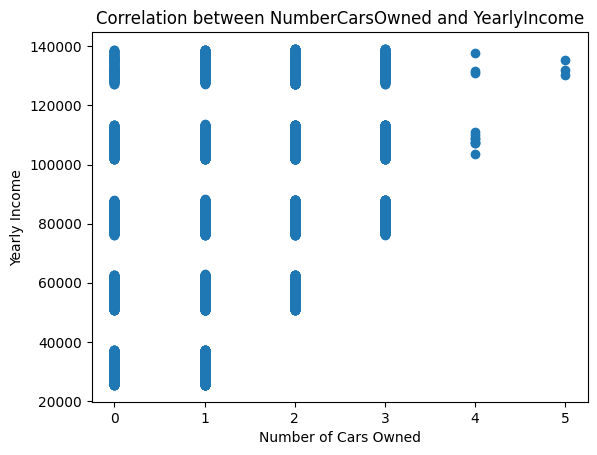

In [15]:
corr = df_proc[["NumberCarsOwned", "YearlyIncome"]].corr().iloc[0,1]
print("Correlation (NumberCarsOwned ~ YearlyIncome):", corr)
import matplotlib.pyplot as plt

plt.scatter(df_proc["NumberCarsOwned"], df_proc["YearlyIncome"])
plt.xlabel("Number of Cars Owned")
plt.ylabel("Yearly Income")
plt.title("Correlation between NumberCarsOwned and YearlyIncome")
plt.show()
